In [3]:
import warnings
warnings.filterwarnings('ignore')

# Week 3 - Diagnosing ARIMA, ARIMAX, and SARIMAX

This week we will really dive into the ways to visually diagnose ARIMA models. When should we use AR or MA processes? How can we visually detect an integrated time series? After we talk about that, we will cover the ARIMA with Exogenous variables (ARIMAX), as well as the SARIMA(X), or seasonal ARIMA model. In the end, we will have a very robust and flexible toolkit for analyzing time series data based on our ARIMA models!

By the end of this lesson, you should be able to:
- Visually diagnose AR and MA processes
- Generate plots to assist in diagnosis of time series models
- Implement adjustments to ARIMA models to fit the observed characteristics of the data
- Implement ARIMA with Seasonal parameters
- Implement ARIMA with exogenous regressors

## 1. Diagnosing an ARIMA Model
---

#### Finding the Right Fit
- Time series models are unqiue in Econometrics: We will nearly always visually diagnose the proper specifications for our model
    - Takes Practice
    - Takes repitition and iteration for any given model

#### The Autocorrelation Function (ACF) - Checking for AutoRegressive Terms
- The ACF illustrates the correlation between an observation and various lags of that same variable
    - Choose how many lags to explore (based on nature of data)
    - Reminder: Correlations will vary between -1 and 1, with 1 being perfect correlation, and -1 being perfect inverse correlation
    - Correlation can be cyclical!

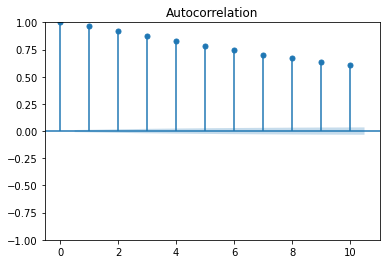

In [4]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

data = pd.read_csv("https://github.com/dustywhite7/Econ8310/blob/master/DataSets/pollutionBeijing.csv?raw=true").dropna()

fig = plot_acf(data['pm2.5'], lags=10)
fig.show()

- In the ACF plot above, we are showing the correlation between an observation and the first 10 lags of that variable
- The figure shows very high correlation for the first lag, with a slowly tapering correlation for each subsequent lagged period
- When we see this type of pattern, it is an indication that there is an AR Process in our time series. Therefore, we should increase the AR term in the order of our model.

#### The Partial Autocorrelation Function (PACF) - Checking for Moving Average Terms
- The PACF provides information analogous to our ACF regarding any MA properties that our time-series may present
    - Choose how many lags to explore (based on nature of data)

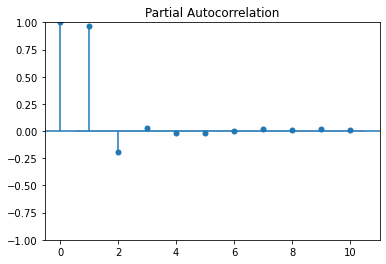

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(data['pm2.5'], lags=10)
fig.show()

- In the above graph, the correlation falls quickly towards zero.
- This is indicative of a lack of MA process in our current time-series.

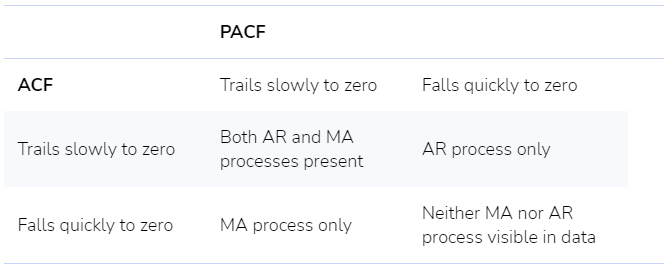

#### Checking for Integration
- When checking for integration, we can use two methods: visual diagnosis or the Augmented Dickey-Fuller test
    - For visual diagnosis, we simply plot the variable of interest, and check whether or not there is a discernible pattern in the time-series.
    - We can use the slope of the fitted OLS line to determine if the data is stationary (close to 0 indicated stationary)

In [11]:
import plotly.express as px

fig = px.scatter(data["pm2.5"], trendline='ols')
fig

- Using the Augmented Dickey-Fuller test, we can clearly reject the null hypothesis, suggesting that our data is in fact stationary.
    - The first number is our threshold, which clears the 1% threshold displayed in the dictonary in the results

In [12]:
from statsmodels.tsa.stattools import adfuller

adfuller(data['pm2.5'], maxlag=12)

(-26.470868122329424,
 0.0,
 12,
 41744,
 {'1%': -3.430506662087084,
  '5%': -2.861609241123293,
  '10%': -2.5668068548124547},
 383188.6995163211)

## 2. Verifying our Model Diagnosis
---

In the first section, we believe that our data is stationary $(d = 0)$, has an AR process $(p \ge 1)$, and has no MA process $(q = 0)$, we should construct an ARIMA(1,0,0) model

#### Building the Model
1. Make the series **stationary**
    - When the ACF falls "quickly" to zero at higher lags, the series is stationary
    - Can also use a unit root test to check for stationarity
2. Use ACF and PACF plots to decide if you should include AR or MA terms in your model
    - Remember that we typically do not use both in the same model
3. Fit the model, and check residual ACF and PACF for lingering signals
4. If there are significant terms in residual ACF or PACF, add AR or MA terms, and try again

In [13]:
import statsmodels.api as sm

arima = sm.tsa.ARIMA(data['pm2.5'], order=(1, 0, 0)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  pm2.5   No. Observations:                41757
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -192487.230
Date:                Mon, 13 Feb 2023   AIC                         384980.461
Time:                        19:22:38   BIC                         385006.380
Sample:                             0   HQIC                        384988.648
                              - 41757                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.6132      4.348     22.682      0.000      90.092     107.135
ar.L1          0.9645      0.001   1282.930      0.000       0.963       0.966
sigma2       590.8014      0.676    873.404      0.000     589.476     592.127
===================================================================================
Ljung-Box (L1) (Q):                1434.85   Jarque-Bera (JB):          12570425.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- With a fitted model, we now want to check whether or not we still see signs of AR or MA process (we should not see any integration at this stage, and we should only have to deal with it before constructing our model)
- The way we make this check is through the Residual ACF and the Residual PACF

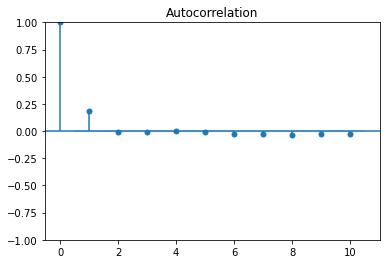

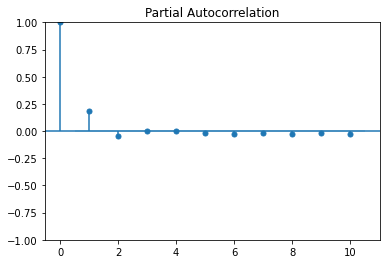

In [16]:
# First, the residual ACF
fig = plot_acf(arima.resid, lags=10)
fig.show()

# Now the residual PACF
fig = plot_pacf(arima.resid, lags=10)
fig.show()

If we need to add AR or MA processes, we can add them one at a time, checking the residuals after each incrementation

In [17]:
arima.forecast(10)

41757    15.073351
41758    18.037648
41759    20.896761
41760    23.654423
41761    26.314233
41762    28.879663
41763    31.354062
41764    33.740661
41765    36.042574
41766    38.262807
Name: predicted_mean, dtype: float64

## 3. ARIMA With Exogenous Variables (ARIMAX)
---

#### ARIMA + X
- We can improve the ARIMA model in many cases if we use ARIMAX (ARIMA with eXogenous variables) models to include exogenous regressors in our estimations
- Very few time-series exist in a vacuum, so being able to use exogenous variables allows us to create a model that can accomodate our understanding that a time-series can be affected by many variables aside from jst the past values of the time series itself
- In order to include exogenous variables, we simply need to include an additional parameter in our model

In [18]:
import patsy as pt

# Using Q() because pm2.5 is a terrible column name and needs to be put in quotes
# Also need to omit our intercept column
y, x = pt.dmatrices("Q('pm2.5') ~ -1 + TEMP + PRES + Iws", data=data)

# Now we just use y as our time-series, and the argument exog=x to include our exogenous regressors
arima = sm.tsa.ARIMA(y, order=(1, 0, 0), exog=x).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                41757
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -192402.478
Date:                Mon, 13 Feb 2023   AIC                         384816.956
Time:                        19:38:09   BIC                         384868.793
Sample:                             0   HQIC                        384833.331
                              - 41757                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3263.7288    122.088     26.732      0.000    3024.440    3503.018
x1            -1.5391      0.067    -23.093      0.000      -1.670      -1.408
x2            -3.0934      0.120    -25.832      0.000      -3.328      -2.859
x3            -0.0406      0.010     -4.088      0.000      -0.060      -0.021
ar.L1          0.9634      0.001   1277.404      0.000       0.962       0.965
sigma2       588.3925      0.676    870.510      0.000     587.068     589.717
===================================================================================
Ljung-Box (L1) (Q):                1274.80   Jarque-Bera (JB):          12743031.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- By simply passing the exog argument with an array of exogenous data, we can include our exogenous variables in our ARIMA model.
- This is possible because an ARIMA model is actually just an OLS model with some new parameters: Lagged values of the dependent variable, and being solved as a maximum-likelihood problem. 

## 4. Seasonal ARIMA Models (SARIMA)
---

Many kinds of time-series data (sales and temperature) tend to fluctuate in predictable patterns. In order to better understand our data and to make forecasts, we want to account for these fluctuations as we build our model

In [22]:
fig = px.line(data['TEMP'][-200:])
fig

ACF for Seasonal data

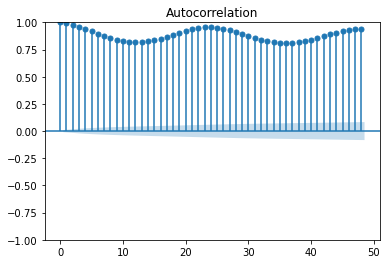

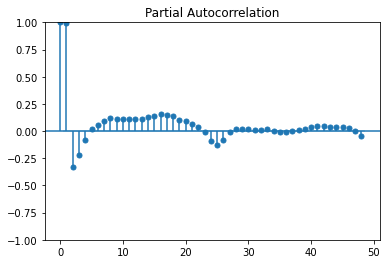

In [23]:
# First, the residual ACF
fig = plot_acf(data['TEMP'], lags=48)
fig.show()

# Now the residual PACF
fig = plot_pacf(data['TEMP'], lags=48)
fig.show()

- It is easy to see that the period 24 hours in teh future has a stronger correlation with the current temperature than the periods in-between.
- In order to accomodate this, we can implement a Seasonal ARIMA model (SARIMA), which can be used with or without exogenous variables

#### SARIMA
- A SARIMA model has additional orders, and can be written as SARIMA $(p, d, q)(P, D, Q, S)$
    - Where:
        - P is the seasonal AR Order
        - D is the seasonal Differencing Order
        - Q is the seasonal MA order
        - S represents the length in observations of one full cycle of seasons


In [25]:
sarima = sm.tsa.SARIMAX(data['TEMP'], order = (1,0,0), seasonal_order = (2,0,0,24)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               TEMP   No. Observations:                41757
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 24)   Log Likelihood              -71235.965
Date:                            Mon, 13 Feb 2023   AIC                         142479.930
Time:                                    20:09:28   BIC                         142514.488
Sample:                                         0   HQIC                        142490.846
                                          - 41757                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9856      0.001   1124.659      0.000       0.984       0.987
ar.S.L24       0.3179      0.004     84.118      0.000       0.311       0.325
ar.S.L48       0.2562      0.004     64.863      0.000       0.248       0.264
sigma2         1.7749      0.007    257.747      0.000       1.761       1.788
===================================================================================
Ljung-Box (L1) (Q):                  95.57   Jarque-Bera (JB):             39657.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

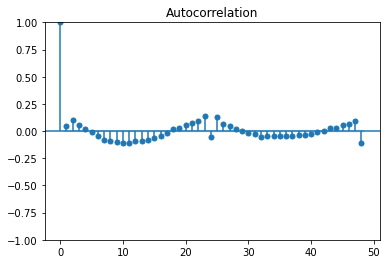

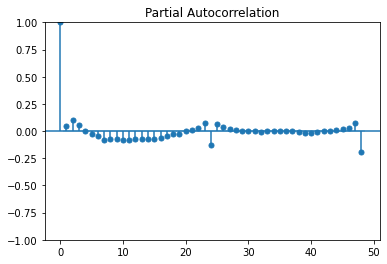

In [26]:
fig = plot_acf(sarima.resid, lags=48)
fig.show()

fig = plot_pacf(sarima.resid, lags=48)
fig.show()

In [ ]:
# WARNING: This cell will NOT run quickly!

y, x = pt.dmatrices("TEMP ~ -1 + Iws + PRES", data=data)

sarima = sm.tsa.statespace.SARIMAX(y, order = (1,0,0), seasonal_order = (2,0,0,24), exog=x).fit()
sarima.summary()

#### SARIMAX
- Where can we go when we have cyclical data?
    - We can introduce "Seasonality" into our model
- The seasonal AutoRegressive Integrated Moving Average Model wih Exogenous Regressors (SARIMAX) is designed to deal with this kind of data and model
- Seasonal Order = (AR Term, Integration Term, MA Term, Length of observations in a cycle)

In [55]:
model = sm.tsa.SARIMAX(y, order=(1,1,0), seasonal_order=(1,1,0,24), exog=x)
reg = model.fit(trend='c')

In [56]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8741
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -27458.025
Date:                            Mon, 13 Feb 2023   AIC                          54930.051
Time:                                    18:46:19   BIC                          54979.561
Sample:                                         0   HQIC                         54946.925
                                           - 8741                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.595e-09   5.03e-08      0.032      0.975    -9.7e-08       1e-07
x1             0.0984      0.011      8.653      0.000       0.076       0.121
x2             1.4308      0.005    293.271      0.000       1.421       1.440
x3             0.8634      1.468      0.588      0.557      -2.015       3.741
ar.L1         -0.3363      0.005    -71.319      0.000      -0.346      -0.327
ar.S.L24      -0.4756      0.004   -106.503      0.000      -0.484      -0.467
sigma2        31.8809      0.204    156.518      0.000      31.482      32.280
===================================================================================
Ljung-Box (L1) (Q):                   3.81   Jarque-Bera (JB):             35120.33
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+23. Standard errors may be unstable.
"""